In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset & Dataloader
transform = transforms.ToTensor()
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

Epoch 1, Loss: 270.4966
Epoch 2, Loss: 249.2217
Epoch 3, Loss: 246.1792
Epoch 4, Loss: 244.6650
Epoch 5, Loss: 243.6226
Epoch 6, Loss: 242.9240
Epoch 7, Loss: 242.3943
Epoch 8, Loss: 241.9445
Epoch 9, Loss: 241.5943
Epoch 10, Loss: 241.2865


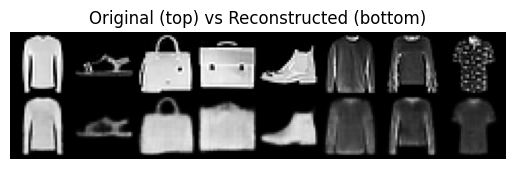

In [ ]:
# VAE Model
class VAE(nn.Module):
    def __init__(self, latent_dim=32):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1),  # 28 -> 14
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),  # 14 -> 7
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(64 * 7 * 7, latent_dim)
 # the mean vector of the latent variables        self.fc_logvar = nn.Linear(64 * 7 * 7, latent_dim)
 # the log-variance vector of the latent variables
        self.fc_decode = nn.Linear(latent_dim, 64 * 7 * 7)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, 2, 1),  # 7 -> 14
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, 2, 1),   # 14 -> 28
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x).view(x.size(0), -1)
        return self.fc_mu(x), self.fc_logvar(x)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.fc_decode(z).view(-1, 64, 7, 7)
        return self.decoder(x)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Loss
def vae_loss(recon, x, mu, logvar):
    bce = F.binary_cross_entropy(recon, x, reduction='sum')
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return bce + kld, bce, kld

# Train
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(10):
    model.train()
    total_loss = 0
    for x, _ in train_loader:
        x = x.to(device)
        optimizer.zero_grad()
        recon, mu, logvar = model(x)
        loss, bce, kld = vae_loss(recon, x, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader.dataset):.4f}")

# Visualization
model.eval()
with torch.no_grad():
    x, _ = next(iter(train_loader))
    x = x.to(device)[:8]
    recon, _, _ = model(x)
    both = torch.cat([x, recon])
    grid = make_grid(both.cpu(), nrow=8)
    plt.imshow(grid.permute(1, 2, 0).squeeze())
    plt.title("Original (top) vs Reconstructed (bottom)")
    plt.axis('off')
    plt.show()


Epoch 1, Total Loss: 16223112.60, BCE: 15064915.40, KLD: 1158197.19
Epoch 2, Total Loss: 14942687.29, BCE: 13865137.61, KLD: 1077549.68
Epoch 3, Total Loss: 14767260.96, BCE: 13693091.05, KLD: 1074169.90
Epoch 4, Total Loss: 14671534.60, BCE: 13600449.63, KLD: 1071084.96
Epoch 5, Total Loss: 14614702.20, BCE: 13544632.06, KLD: 1070070.13
Epoch 6, Total Loss: 14571770.06, BCE: 13503849.64, KLD: 1067920.40
Epoch 7, Total Loss: 14539431.41, BCE: 13475547.62, KLD: 1063883.79
Epoch 8, Total Loss: 14515105.00, BCE: 13452301.25, KLD: 1062803.75
Epoch 9, Total Loss: 14495340.90, BCE: 13434635.36, KLD: 1060705.54
Epoch 10, Total Loss: 14473029.06, BCE: 13415477.34, KLD: 1057551.73


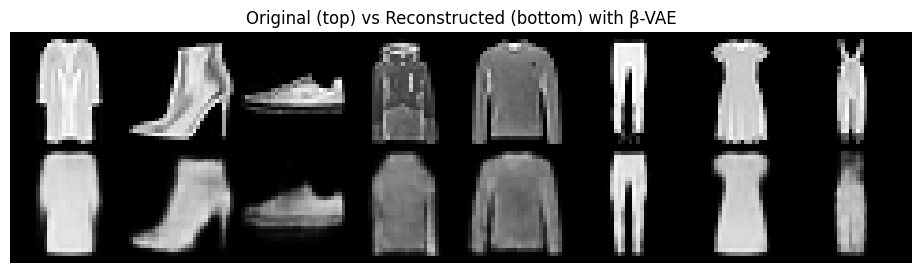

In [ ]:
# β-VAE Model
class BetaVAE(nn.Module):
    def __init__(self, latent_dim=32):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(64 * 7 * 7, latent_dim)
        self.fc_logvar = nn.Linear(64 * 7 * 7, latent_dim)
        self.fc_decode = nn.Linear(latent_dim, 64 * 7 * 7)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, 2, 1),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x).view(x.size(0), -1)
        return self.fc_mu(x), self.fc_logvar(x)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.fc_decode(z).view(-1, 64, 7, 7)
        return self.decoder(x)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# β-VAE loss function
def beta_vae_loss(recon, x, mu, logvar, beta=4.0):
    bce = F.binary_cross_entropy(recon, x, reduction='sum')
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return bce + beta * kld, bce, kld

# Train model
model = BetaVAE(latent_dim=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 10
beta = 1.0

for epoch in range(num_epochs):
    model.train()
    total_loss, total_bce, total_kld = 0, 0, 0
    for x, _ in train_loader:
        x = x.to(device)
        optimizer.zero_grad()
        recon, mu, logvar = model(x)
        loss, bce, kld = beta_vae_loss(recon, x, mu, logvar, beta)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_bce += bce.item()
        total_kld += kld.item()
    save_name = "checkpoints/beta_vae" + str(epoch+1) + ".pth"
    torch.save(model.state_dict(), save_name)
    print(f"Epoch {epoch+1}, Total Loss: {total_loss:.2f}, BCE: {total_bce:.2f}, KLD: {total_kld:.2f}")

# Visualize results
import numpy as np
model.eval()
with torch.no_grad():
    x, _ = next(iter(train_loader))
    x = x.to(device)[:8]
    recon, _, _ = model(x)
    comparison = torch.cat([x, recon])
    grid = make_grid(comparison.cpu(), nrow=8)
    plt.figure(figsize=(12, 3))
    plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)).squeeze(), cmap="gray")
    plt.axis('off')
    plt.title("Original (top) vs Reconstructed (bottom) with β-VAE")
    plt.show()

## Load model from checkpoint

C:\Users\Spencer\AppData\Local\Temp\ipykernel_14360\4262724604.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("checkpoints/beta_vae8.pt

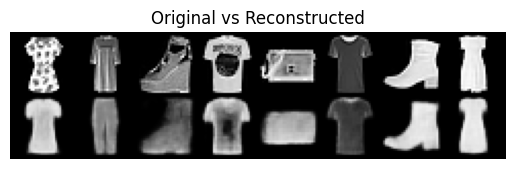

In [29]:
model = BetaVAE(latent_dim=32)
model.load_state_dict(torch.load("checkpoints/beta_vae8.pth", map_location=device))
model.to(device)
model.eval()



with torch.no_grad():
    sample_x, _ = next(iter(train_loader))
    sample_x = sample_x.to(device)[:8]
    recon_x, mu, logvar = model(sample_x)  

comparison = torch.cat([sample_x, recon_x])
grid = make_grid(comparison.cpu(), nrow=8)
plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)).squeeze(), cmap="gray")
plt.axis('off')
plt.title("Original vs Reconstructed")
plt.show()


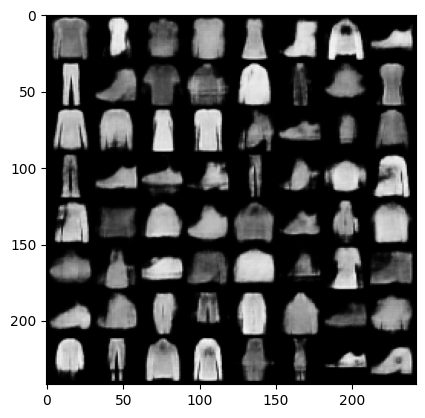

In [30]:
latent_dim = 32
z = torch.randn(64, latent_dim).to(device)
samples = model.decode(z).cpu()
grid = make_grid(samples, nrow=8)
plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap='gray')
